# ROMMA Scraping again

Almost everyone knows that you can get time series by scraping pages.


https://www.infoclimat.fr/climatologie/normales-records/1981-2010/grenoble-lvd/valeurs/38538002.html

http://romma.fr/station_24.php?id=4&tempe=1

So I ended up doing averaging the data and doing some linear regression - 
all the variables:

- temperature
- humidity 
- solar radiation
- windiness

seem to be correlated.


In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import time
import requests
import html

In [297]:
pp = re.compile('station_24\.php\?id=(\d+)"><b>(.*?),(.*?)m')
user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'http://romma.fr/frame_station24.php'

r = requests.get('http://romma.fr', 
                 headers=user_agent)

stations = pp.findall(r.text)

In [300]:
code, name, alt = zip(*stations)
alt = [int(x) for x in alt]

(array([ 6., 12., 21., 21., 11.,  8.,  7., 19., 11., 12.,  7.,  6., 10.,
         6.,  3.,  6.,  5.,  4.,  5.,  5.,  3.,  2.,  1.,  3.,  1.,  1.,
         0.,  1.,  0.,  1.]),
 array([  17. ,  120.4,  223.8,  327.2,  430.6,  534. ,  637.4,  740.8,
         844.2,  947.6, 1051. , 1154.4, 1257.8, 1361.2, 1464.6, 1568. ,
        1671.4, 1774.8, 1878.2, 1981.6, 2085. , 2188.4, 2291.8, 2395.2,
        2498.6, 2602. , 2705.4, 2808.8, 2912.2, 3015.6, 3119. ]),
 <a list of 30 Patch objects>)

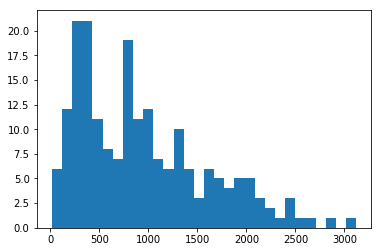

In [303]:
plt.hist(alt, bins=30)

In [414]:
pr = re.compile('<tr>(.*?)</tr>', re.DOTALL)

url = 'http://romma.fr/carte.php'

#https://stackoverflow.com/questions/38489386/python-requests-403-forbidden
user_agent = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36",
             'Host': 'romma.fr'}

params = {'dept' : 0, 
          'param': 'temperature',
          'mobile' : 0,
          'carteinterne': 0}
    
r = requests.get(url, 
                headers=user_agent,
                params=params
)
   
r
    

<Response [200]>

In [415]:
px = re.compile('overlib\((.*?)CAPTION,(.*?)\);',re.DOTALL)
tt = re.compile("<td class=(.*?)>(.*?)</td>")
#tt = re.compile(r"<td class=>\'blanc\'</td>")

xxx = []
for k, ss in enumerate(px.findall(r.text)):
    if k  % 2: continue
    dd, sn = ss
    xxx.append( sn + [ y for x, y in tt.findall(dd) if 'blanc' in x][0] )
xxx = ' '.join(xxx)

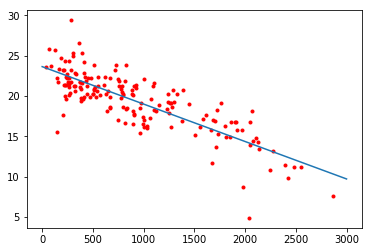

In [416]:
nps = re.compile('\((\d+).*?>(.*?)<')
# drop anywhere that hasn't give a valid temperature
valid_pairs = [x for x in nps.findall(xxx) if '--' not in x[1]]

#cast strings to numbers
A, T = list(zip(* valid_pairs ) )
A = [int(x) for x in A]
T = [float(x) for x in T]
plt.plot(A,T,'r.') 

vv = stats.linregress(A,T)
X = np.array([0,3000])
plt.plot(X, vv.slope*X + vv.intercept)



In [417]:
1/vv.slope

-215.49875347090557

In [313]:
GET /carte.php?dept=0&param=temperature&mobile=0&carteinterne=0 HTTP/1.1
Host: romma.fr
Connection: keep-alive
Cache-Control: max-age=0
DNT: 1
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Accept-Encoding: gzip, deflate
Accept-Language: en-IE,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,zh-CN;q=0.6,zh;q=0.5,en-US;q=0.4,nl;q=0.3
Cookie: rid=51Yg44; ui-tabs-1=1; paramtab=0


<Response [403]>

http://romma.fr/carte.php?dept=0&param=temperature&mobile=0&carteinterne=0

/html/body/div[2]/div[171]

#carte > div:nth-child(321)

document.querySelector("#carte > div:nth-child(321)")
document.querySelector("#carte > div:nth-child(46)")

document.querySelector("#carte > div:nth-child(213)")


## Extracting the data arrays

The good stuff is hiden in a frame but is easily accesible

In [158]:
def html2arrays(txt):
    def val2float(x):
        if x == '':
            return float('nan')
        return float(x)

    #I was dumping this from chrome and it  imposes fixed line widths
    #txt = re.sub('=\n','',txt)

    #json style null->nan
    #because we are going to cast string to float later
    txt = re.sub('null', 'nan', txt)

    pp = re.compile( 'var ([\w|\s]*?)array=.*?\[(.*?)\]', re.DOTALL)
    mm = pp.findall(txt)

    data = dict(mm)
    data.keys()

    fields = ['time', 'temp', 'pluie', 'intenspluie', 
              'pression', 'hum', 'rad','rafale','vent','ventdir']
    arrays = {}
    for key in fields:
       
        try:
            arrays[key] = np.array( [ val2float(x) for x in data[key].split(',')])
        except:
            print(key)
            
        #continue
        
        #this fixes holes in the time series
        if key == 'time':
            index = (arrays[key] - arrays[key][0])/600000 
            index = index.astype(np.int32)
            index[index > 4463] = 4463 # just to be safe
   
        else:
            fix = np.zeros(4464)
            fix[index] = arrays[key]
            arrays[key] = fix
            
    return arrays
        
def get_station(ref_num=6):       
    url = 'http://romma.fr/frame_station24.php' # why is this hard coded ?
    user_agent = {'User-agent': 'Mozilla/5.0'}
    
    r = requests.post(url, 
                     headers=user_agent,
                     params={"id_station":ref_num, "tempe":1})
    
    return r.text

smh = 4
voiron = 109
orange = 54
data = {}
for k in [3,5,109,44,4,6]: 
    tt = get_station(ref_num=k)
    meteo = html2arrays(tt)
    data[k] = meteo


Vizille = 5 seemed to be out of sync with the other sites

In [214]:
for k in [3,5,109,44,4,6]: 
    print(data[k]['time'][0])

1592629200000.0
1592629200000.0
1592629200000.0
1592629200000.0
1592629200000.0
1592629200000.0


In [155]:
(1592553600000.0 - 1592546400000.0) / 60000

120.0

In [215]:
import pickle

def hour(x):
    tt = time.localtime(x/1000)
    return tt.tm_hour + tt.tm_min/60
    
day = 24*6

# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in data[4]['time'][:day]])


# use pickle and not json as we have np.array
fn = '21July.pkl'
data['times'] = times
with open(fn,'wb') as fp:
    pickle.dump(data,fp)

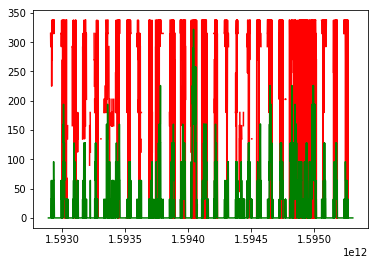

In [181]:
meteo = data[4]


ww = 28*24*6
plt.plot(meteo['time'][-ww:], meteo['ventdir'][-ww:],'r')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:]*20,'g')

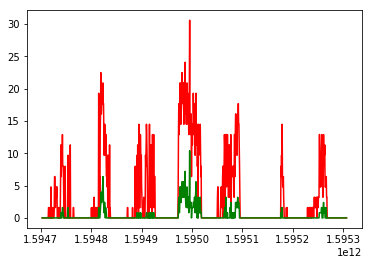

In [163]:
ww = 7*24*6
plt.plot(meteo['time'][-ww:], meteo['rafale'][-ww:],'r')
#plt.plot(tt[-ww:],np.diff(temp,n=1)[-ww:],'b')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:],'g')

    

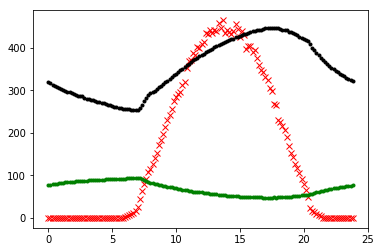

In [164]:

def tot(key='rad'):
    day = 24*6
    tot = np.zeros((day), dtype=np.float32)
    for k in range(31):
        tot += np.roll(meteo[key], k*day)[:day]
    return tot

    
# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in meteo['time'][:day]])


#plt.plot( times, tot(key='vent'),'b.')
plt.plot( times ,tot(key='rad')/50,'rx')
plt.plot( times ,tot(key='temp')/2,'k.')
plt.plot( times ,tot(key='hum')/28,'g.')

In [163]:
times = np.arange(144)/6


# There must be a better way

the function tot() kind of sucks  
- it's not very **numpy**.

what we really need is to 

1. reshape so that a row represents a day 
1. sum over the columns to get the average.

In [21]:
np.arange(12).reshape(3,4), np.sum(np.arange(12).reshape(3,4), axis=0)

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]), array([12, 15, 18, 21]))

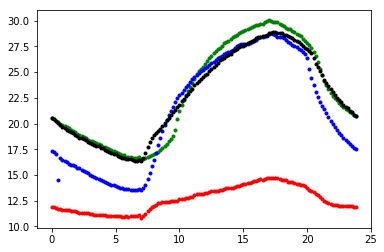

In [166]:
npts = 4464
ndays = npts//24//6

cols = [ x for x in 'rgbky']

for k in [3,4,5,6]:
    mm = data[k]['temp'].reshape(ndays, 24*6)/ndays
    mm[mm>1000] = 0
    plt.plot(times, np.sum(mm, axis=0), cols.pop(0) + '.')

In [167]:
npts = 4464
ndays = npts//24//6


blacklist = ['time', 'pression', 'ventdir', 'pluie', 'intenspluie']
averages = {}

for station, series in data.items():
    #I stored the times as a field it's an ndarray not dict
    if station == 'times': continue
    tmp = {}
    for tag, xx in series.items():
        if tag in blacklist: continue
        mm = xx.reshape(ndays, 24*6)/ndays
        #clean up the nan
        mm[np.isnan(mm)] = 0
        #kill outliers in rad
        mm[mm>1000] = 0
        tmp[tag] = np.sum(mm, axis=0)
    averages[station] = tmp
     

## Let's show them all in a multiplot

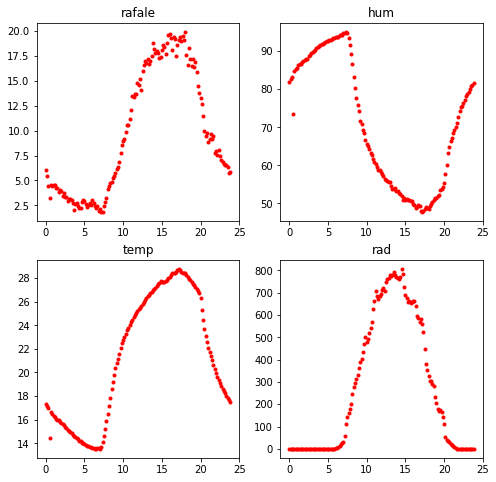

In [216]:
fig, axs = plt.subplots(2,2)
#[axi.set_axis_off() for axi in axs.ravel()]
fig.set_size_inches(8,8)

meteo = averages[5]

for k,tag in enumerate(['rafale','temp','hum','rad']):

    axs[k % 2 , k // 2].plot(times, meteo[tag],'r.')
    axs[k % 2 , k // 2].set_title(tag)
    

## Humidity and temperature

they seem to be correlated so let's do a linear regression to see if that is actually the case.

There might be **nan**s in the arrays so mask them out before doing the regression.

In [221]:
from scipy import stats

cors = {}
for k in [3,4,5,6,109]:
    x = data[k]
    X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
    Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

    mask = ~(np.isnan(X) | np.isnan(Y))
    cors[k] = stats.linregress( X[mask], Y[mask])

In [222]:
cors

{3: LinregressResult(slope=-0.4521593420264222, intercept=85.15287138984661, rvalue=-0.38564285778340424, pvalue=1.8119337773278526e-06, stderr=0.09078166694120798),
 4: LinregressResult(slope=-3.0218851479491944, intercept=131.02476950401666, rvalue=-0.9972050918770983, pvalue=7.052354144807788e-162, stderr=0.018999597245034992),
 5: LinregressResult(slope=-3.045295531204571, intercept=135.32976589730515, rvalue=-0.9944270164296619, pvalue=1.221080175396012e-140, stderr=0.027093512611454387),
 6: LinregressResult(slope=-3.3923551234092395, intercept=139.42847465719487, rvalue=-0.9967246584007131, pvalue=5.3981604125316884e-157, stderr=0.023097731352487678),
 109: LinregressResult(slope=-2.6754122057920853, intercept=120.16521149892878, rvalue=-0.976752216382286, pvalue=1.5905017835848804e-95, stderr=0.04962598905569754)}

### Retiming

I have to plot the data against time otherwise it's offset
so that midnight is no longer at zero.

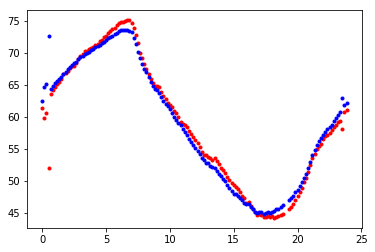

In [225]:
k = 109

vv = cors[k]
a, b = vv.slope, vv.intercept

x = data[k]
X = np.sum( x['temp'].reshape(ndays, 24*6)/ndays, axis=0)
Y = np.sum( x['hum'].reshape(ndays, 24*6)/ndays, axis=0)

plt.plot(times,Y,'r.')
#plt.plot(times,X,'g.')
plt.plot(times, a*X + b, 'b.')

## Finally calculate the time of max temperature

I checked this by hand it seems to be pretty accurate

In [226]:
time_tics = data[3]['time']

TS = data[109]['rad']

numdays = 30
ts = [i for i in range(-1,-1 - numdays*24*6, -24*6)]

#use smh as a reference the others don't seem reliable
day_intervals = [list(zip( TS, time_tics))[i:j] 
                                       for i,j in  zip(ts[1:],ts)]
mx = [max(day) for day in day_intervals if day]
x,y = zip(*mx)
[time.ctime(t/1000.)[4:16] for t in y]

['Jul 20 13:40',
 'Jul 19 13:50',
 'Jul 18 14:20',
 'Jul 17 13:00',
 'Jul 16 12:30',
 'Jul 15 15:40',
 'Jul 14 11:50',
 'Jul 13 13:30',
 'Jul 12 13:50',
 'Jul 11 13:30',
 'Jul 10 12:30',
 'Jul  9 13:40',
 'Jul  8 13:50',
 'Jul  7 13:40',
 'Jul  6 12:20',
 'Jul  5 13:50',
 'Jul  4 13:30',
 'Jul  3 14:20',
 'Jul  2 14:10',
 'Jul  1 15:40',
 'Jun 30 13:40',
 'Jun 29 12:40',
 'Jun 28 15:20',
 'Jun 27 12:50',
 'Jun 26 14:10',
 'Jun 25 13:20',
 'Jun 24 13:30',
 'Jun 23 13:30',
 'Jun 22 12:20']

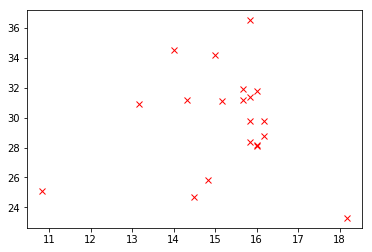

In [76]:
XS, YS = zip(*mx)
YS = [(int(y)//1000 % (24*3600)) /3600 for y in YS]
plt.plot(YS,XS, 'rx')

## Calculate the length of a day

In [209]:
for k, y in averages.items():
    if max(y['rad']) == 0: continue
    day_light = times[y['rad'] > 4]
    print(k, max(day_light), min(day_light) )

3 21.333333333333332 6.0
5 21.333333333333332 6.166666666666667
109 21.166666666666668 6.0
4 21.333333333333332 6.166666666666667
6 21.333333333333332 6.166666666666667


In [208]:
min(averages[44]['rad'])

0.0

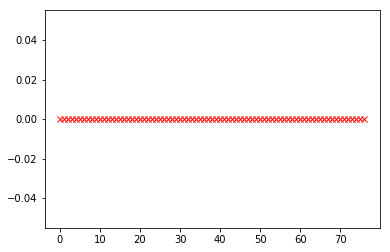

In [126]:
trans = [int(y)//1000 % (24*3600) /3600 for y in night]
trans = [ min(x,8) for x in trans ]

plt.plot(range(len(trans)),trans,'rx')

In [24]:
! ./.g


[master 55a8f72] web
 4 files changed, 898 insertions(+), 872 deletions(-)
 create mode 100644 19July.json
 create mode 100644 19July.pkl
 create mode 100644 20July.pkl
 rewrite romma_again.ipynb (62%)
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 4 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 340.26 KiB | 965.00 KiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), done.
To https://github.com/macbuse/ROMMA.git
   6d7d020..55a8f72  master -> master


In [111]:
4464 - 4455

9

In [115]:
tt = get_station(ref_num=109)
meteo = html2arrays(tt)
len(meteo['time'])

4455

In [135]:
index = (meteo['time'] - meteo['time'][0])/600000 
index = index.astype(np.int32)

In [139]:
uu = np.diff(index)
sum( uu[uu > min(uu)] - min(uu) )

9

In [128]:
4464 // 24 //6

31

In [411]:
! ./.g

[master 9bb8207] web
 2 files changed, 1445 insertions(+), 1312 deletions(-)
 rewrite romma_again.ipynb (82%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 25.10 KiB | 1.79 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/ROMMA.git
   6808563..9bb8207  master -> master


In [410]:
!pwd


/home/gregmcshane/ROMMA
